<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span></li><li><span><a href="#load-stocks-csv" data-toc-modified-id="load-stocks-csv-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load stocks csv</a></span></li><li><span><a href="#check-agent-limit-order" data-toc-modified-id="check-agent-limit-order-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>check agent limit order</a></span></li><li><span><a href="#meta-algorithm" data-toc-modified-id="meta-algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>meta algorithm</a></span><ul class="toc-item"><li><span><a href="#MMMW" data-toc-modified-id="MMMW-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>MMMW</a></span><ul class="toc-item"><li><span><a href="#plots-day-1" data-toc-modified-id="plots-day-1-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>plots day 1</a></span></li><li><span><a href="#plots-day-2" data-toc-modified-id="plots-day-2-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>plots day 2</a></span></li></ul></li></ul></li><li><span><a href="#results-table" data-toc-modified-id="results-table-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>results table</a></span><ul class="toc-item"><li><span><a href="#Best" data-toc-modified-id="Best-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Best</a></span></li><li><span><a href="#MMMW" data-toc-modified-id="MMMW-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>MMMW</a></span></li><li><span><a href="#uniform" data-toc-modified-id="uniform-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>uniform</a></span></li><li><span><a href="#final-table" data-toc-modified-id="final-table-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>final table</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style(style='white') 

from tqdm.auto import tqdm

In [3]:
from dotenv import load_dotenv
import os
import finnhub

In [4]:
load_dotenv()  # take environment variables from .env.

True

## load data

In [55]:
API_KEY = os.getenv("API_KEY")
# print(f"using {API_KEY=} for api")

In [56]:
# Setup client
finnhub_client = finnhub.Client(api_key=API_KEY)

In [149]:
from_date = pd.to_datetime("2021-11-08")
to_date = pd.to_datetime("2021-11-12")
symbol = 'AAPL'

In [150]:
print(f"loading date {from_date=} {to_date=}")

loading date from_date=Timestamp('2021-11-08 00:00:00') to_date=Timestamp('2021-11-12 00:00:00')


In [151]:
symbols = ['AAPL', 'MSFT', 'HPQ', 'WMT']

In [152]:
results = []
for symbol in symbols:
    res = finnhub_client.stock_candles(
        symbol, 1, int(from_date.timestamp()), int(to_date.timestamp())
    )
    res['symbol'] = symbol
    results.append(res)

In [153]:
df = pd.DataFrame()
for res in results:
    df = pd.concat([df, pd.DataFrame(res)])

In [154]:
df['timestamp'] = pd.to_datetime(df['t'], unit='s')

In [155]:
df.head()

,c,h,l,o,s,t,v,symbol,timestamp
0,151.24,151.24,151.08,151.08,ok,1636362000,7019,AAPL,2021-11-08 09:00:00
1,151.24,151.24,151.24,151.24,ok,1636362060,966,AAPL,2021-11-08 09:01:00
2,151.30,151.35,151.30,151.30,ok,1636362120,4677,AAPL,2021-11-08 09:02:00
3,151.28,151.35,151.28,151.30,ok,1636362180,2127,AAPL,2021-11-08 09:03:00
4,151.30,151.30,151.30,151.30,ok,1636362240,466,AAPL,2021-11-08 09:04:00


In [156]:
df.timestamp.max()

Timestamp('2021-11-12 00:00:00')

In [157]:
df.to_csv('stocks.csv', index=False)

## load stocks csv

In [158]:
df = pd.read_csv('stocks.csv')
df['timestamp'] = df['timestamp'].astype('datetime64[ns]')

In [159]:
symbol = 'AAPL'

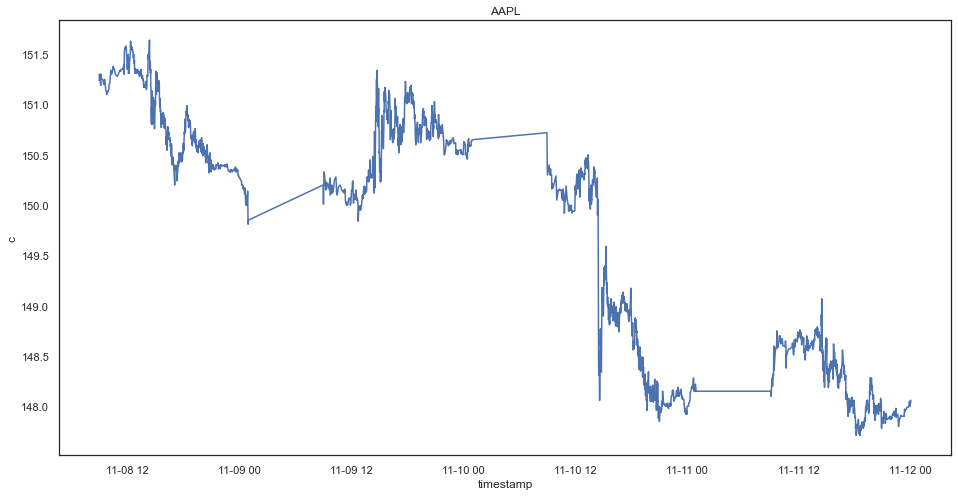

In [160]:
fig, axs = plt.subplots(figsize=(16, 8))
plt.title(symbol)
sns.lineplot(x='timestamp', y='c', data=df[df.symbol == symbol]);

## check agent limit order

In [161]:
from Agent import Agent

In [162]:
p_1 = 1

In [163]:
a = Agent(b=0.5, alpha=10, a_1=p_1)

In [164]:
a.limit_order(p_current=1.5, p_next=4)

In [165]:
a.inventory

-2510

In [166]:
a.cash

6902.499999999999

## meta algorithm

MMMW, MMFPL, simple Follow-The-Leader2 (FTL), and simple uniform averaging over all strategies

In [254]:
Beta = np.array([1, 2, 3, 4, 5, 10, 20, 40, 80, 100]) / 100 # in dollars, not in cents
N = len(Beta)
B = np.max(Beta)
ALPHA = 1

In [255]:
Beta

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.1 , 0.2 , 0.4 , 0.8 , 1.  ])

In [256]:
agent_to_beta = {i: b for i, b in enumerate(Beta)}
beta_to_agent = {b: i for i, b in enumerate(Beta)}

### MMMW

In [307]:
def update_weights(weights_prev, eta, values_prev, values_current):
    weights_new = weights_prev * np.exp(eta * (values_current - values_prev))
    weights_new = weights_new / np.sum(weights_new)  # normalization Z_t
    return weights_new

In [308]:
def get_values(agents, p):
    return np.array([a.value(p) for a in agents])
def get_inventories(agents):
    return np.array([a.inventory for a in agents])
def get_cash(agents):
    return np.array([a.cash for a in agents])

In [309]:
def eta(t):
    return np.sqrt(np.log(N) / t)

In [310]:
def market_order(X, p_current):
    # X>0 => buying
    # X<0 => selling
    cash_diff = -X * p_current
    inventory_diff = X
    return cash_diff, inventory_diff

#### plots day 1

In [311]:
symbol = 'MSFT'
df_symbol = df[df.symbol == symbol]
day = df_symbol['timestamp'].dt.date.unique()[0]
df_day = df_symbol[df_symbol['timestamp'].dt.date == day]

df_day = df_day[df_day.timestamp.dt.hour >= 12]
df_day = df_day[df_day.timestamp.dt.hour <= 21]

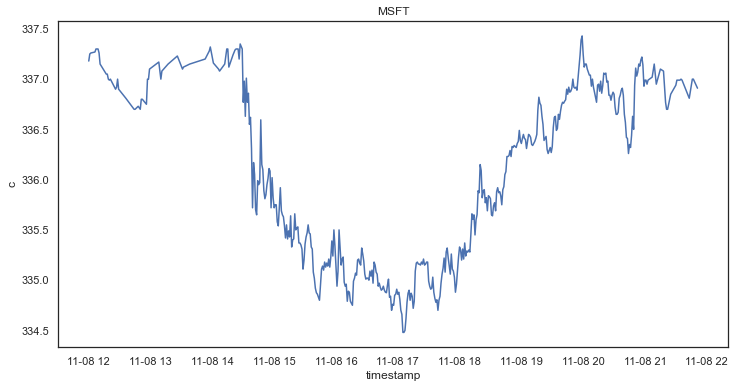

In [312]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.title(symbol)
sns.lineplot(x='timestamp', y='c', data=df_day);

In [313]:
weights = np.array([1/N]*N)
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [314]:
p_1 = df_day['c'].iloc[0]

In [315]:
agents = [Agent(b=b, alpha=ALPHA, a_1=p_1) for b in Beta]

In [324]:
w = []  # weights at each step
values = []  # value at each step

G_t = 0

for t in range(1, len(df_day)-1):
    p_current = df_day.iloc[t]['c']
    p_next = df_day.iloc[t+1]['c']

    current_values = get_values(agents, p_current)
    current_inventories = get_inventories(agents)
    for a in agents:
        a.limit_order(p_current, p_next)
    next_values = get_values(agents, p_next)
    next_inventories = get_inventories(agents)
    
    eta_current = eta(t)
    diffs = current_values.reshape(1, -1) - current_values.reshape(-1, 1)  
    diffs = np.abs(diffs)
    G_t = max(np.max(diffs), G_t)
    
    eta_current = min(eta_current, G_t)
    
    w.append(weights)
    values.append(current_values)
    
    weights_old = weights
    weights = update_weights(weights, eta_current, current_values, next_values)
    
    
w = np.array(w)
values = np.array(values)

In [325]:
# not needed
tmp = pd.DataFrame(w).add_prefix('agent_')
tmp['T'] = tmp.index
tmp = pd.wide_to_long(tmp, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'weight'})
tmp['agent'] = (100 * tmp['agent'].map(agent_to_beta)).astype(int).astype(str)
# tmp['agent'] = tmp['agent'].astype(str)

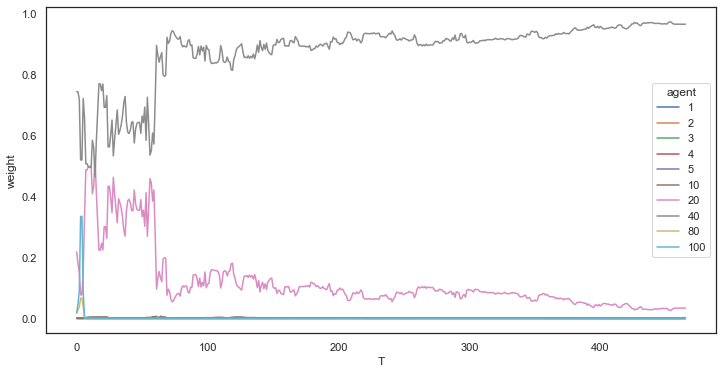

In [326]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='weight', hue='agent', data=tmp);

In [327]:
value_df = pd.DataFrame((w * values).sum(axis=1), columns=['value'])
value_df['T'] = value_df.index

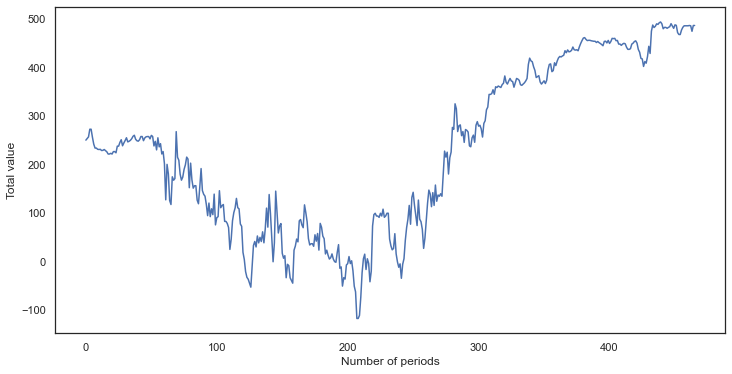

In [328]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='value', data=value_df, ax=axs);
plt.xlabel('Number of periods')
plt.ylabel('Total value');
# plt.grid(None);

In [329]:
value_df = pd.DataFrame(values).add_prefix('agent_')
value_df['T'] = value_df.index
value_df = pd.wide_to_long(value_df, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'value'})
# value_df['agent'] = value_df['agent'].astype(str)
value_df['agent'] = (100 * value_df['agent'].map(agent_to_beta)).astype(int).astype(str)

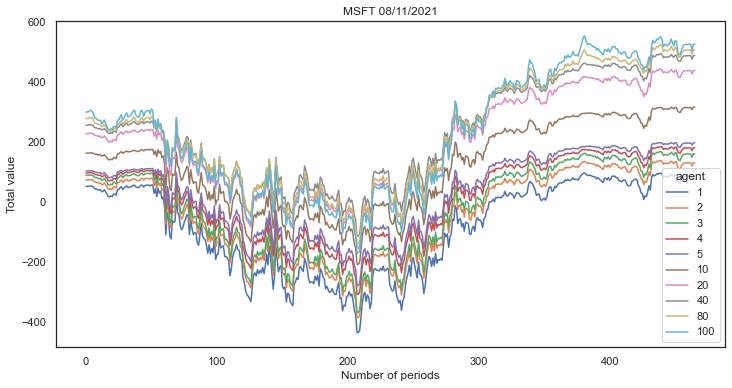

In [330]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='value', hue='agent', data=value_df)
plt.title(f'{symbol} {pd.to_datetime(day).strftime("%d/%m/%Y")}')

plt.xlabel('Number of periods')
plt.ylabel('Total value');

#### plots day 2

In [331]:
symbol = 'MSFT'
df_symbol = df[df.symbol == symbol]
day = df_symbol['timestamp'].dt.date.unique()[2]
df_day = df_symbol[df_symbol['timestamp'].dt.date == day]

df_day = df_day[df_day.timestamp.dt.hour >= 12]
df_day = df_day[df_day.timestamp.dt.hour <= 21]

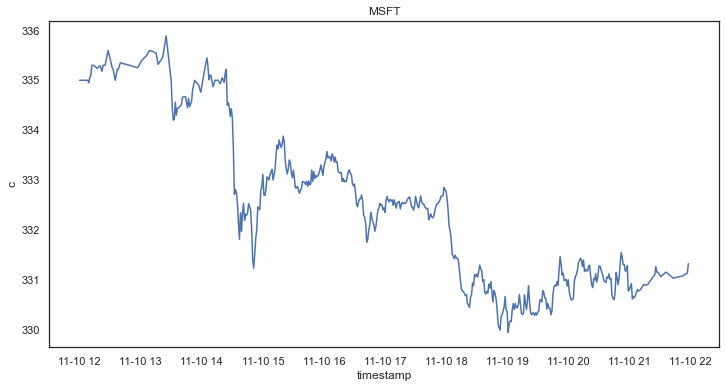

In [332]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.title(symbol)
sns.lineplot(x='timestamp', y='c', data=df_day);

In [333]:
weights = np.array([1/N]*N)
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [334]:
p_1 = df_day['c'].iloc[0]

In [335]:
agents = [Agent(b=b, alpha=ALPHA, a_1=p_1) for b in Beta]

In [336]:
w = []  # weights at each step
values = []  # value at each step

G_t = 0

for t in range(1, len(df_day)-1):
    p_current = df_day.iloc[t]['c']
    p_next = df_day.iloc[t+1]['c']

    current_values = get_values(agents, p_current)
    current_inventories = get_inventories(agents)
    for a in agents:
        a.limit_order(p_current, p_next)
    next_values = get_values(agents, p_next)
    next_inventories = get_inventories(agents)
    
    eta_current = eta(t)
    diffs = current_values.reshape(1, -1) - current_values.reshape(-1, 1)  
    diffs = np.abs(diffs)
    G_t = max(np.max(diffs), G_t)
    
    eta_current = min(eta_current, G_t)
    
    w.append(weights)
    values.append(current_values)
    
    weights_old = weights
    weights = update_weights(weights, eta_current, current_values, next_values)
    
    
w = np.array(w)
values = np.array(values)

In [337]:
# not needed
tmp = pd.DataFrame(w).add_prefix('agent_')
tmp['T'] = tmp.index
tmp = pd.wide_to_long(tmp, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'weight'})
tmp['agent'] = (100 * tmp['agent'].map(agent_to_beta)).astype(int).astype(str)
# tmp['agent'] = tmp['agent'].astype(str)

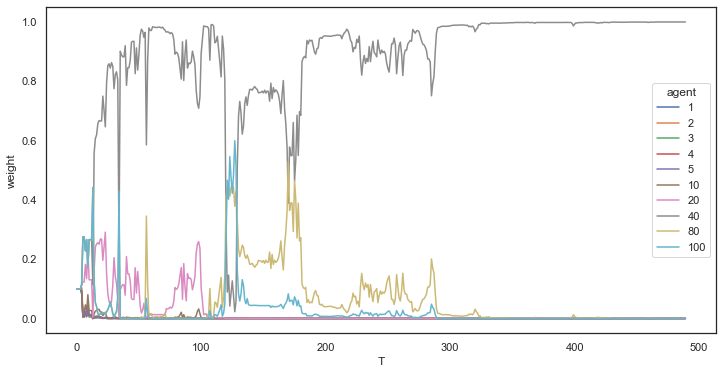

In [338]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='weight', hue='agent', data=tmp);

In [339]:
value_df = pd.DataFrame((w * values).sum(axis=1), columns=['value'])
value_df['T'] = value_df.index

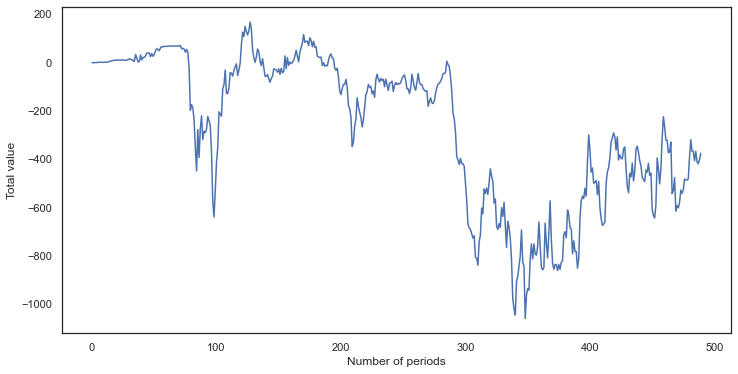

In [340]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='value', data=value_df, ax=axs);
plt.xlabel('Number of periods')
plt.ylabel('Total value');
# plt.grid(None);

In [341]:
value_df = pd.DataFrame(values).add_prefix('agent_')
value_df['T'] = value_df.index
value_df = pd.wide_to_long(value_df, ['agent_'], i='T', j='agent').reset_index().rename(columns={'agent_': 'value'})
# value_df['agent'] = value_df['agent'].astype(str)
value_df['agent'] = (100 * value_df['agent'].map(agent_to_beta)).astype(int).astype(str)

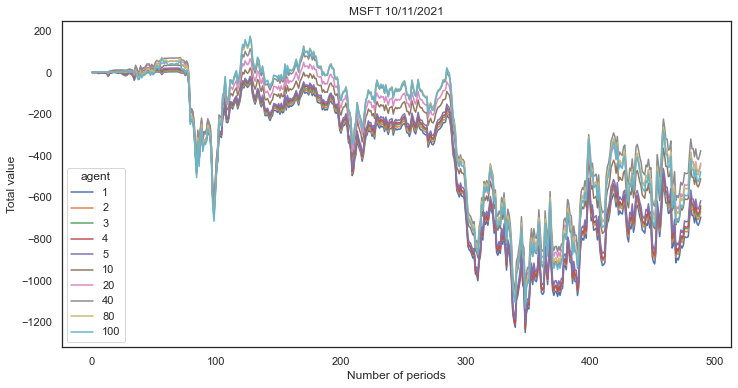

In [342]:
fig, axs= plt.subplots(figsize=(12, 6))
sns.lineplot(x='T', y='value', hue='agent', data=value_df)
plt.title(f'{symbol} {pd.to_datetime(day).strftime("%d/%m/%Y")}')

plt.xlabel('Number of periods')
plt.ylabel('Total value');

## results table

In [412]:
symbols_for_table = ['MSFT', 'HPQ', 'WMT']

In [413]:
t = df.copy()
t['date'] = t['timestamp'].dt.date
t = t[t.symbol.isin(symbols_for_table)]

In [414]:
res_df = t.groupby(['symbol', 'date']).size().reset_index().rename(columns={0: 'T'})

In [415]:
res_df

,symbol,date,T
0,HPQ,2021-11-08,398
1,HPQ,2021-11-09,405
2,HPQ,2021-11-10,406
3,HPQ,2021-11-11,391
4,MSFT,2021-11-08,511
5,MSFT,2021-11-09,543
6,MSFT,2021-11-10,558
7,MSFT,2021-11-11,532
8,WMT,2021-11-08,422
9,WMT,2021-11-09,410


### Best

In [441]:
def get_best_values(df_day):
    weights = np.array([1/N]*N)
    p_1 = df_day['c'].iloc[0]
    agents = [Agent(b=b, alpha=ALPHA, a_1=p_1) for b in Beta]
    
    values = []  # value at each step
    for t in range(1, len(df_day)-1):
        p_current = df_day.iloc[t]['c']
        p_next = df_day.iloc[t+1]['c']

        current_values = get_values(agents, p_current)
        current_inventories = get_inventories(agents)
        for a in agents:
            a.limit_order(p_current, p_next)
        next_values = get_values(agents, p_next)
        next_inventories = get_inventories(agents)
        values.append(current_values)
    values = np.array(values)
    
    return values[-1].max()  # simply taking the max out of final values for each agent

In [442]:
res_best = []
for symbol in symbols_for_table:
    for day in df['timestamp'].dt.date.unique()[:-1]:
        df_symbol = df[df.symbol == symbol]
        df_day = df_symbol[df_symbol['timestamp'].dt.date == day]

        df_day = df_day[df_day.timestamp.dt.hour >= 12]
        df_day = df_day[df_day.timestamp.dt.hour <= 21]
        
        v = get_best_values(df_day)
        res_best.append((symbol, day, v))

In [443]:
res_best = pd.DataFrame(res_best, columns=['symbol', 'date', 'Best'])

### MMMW

In [416]:
def get_mmmw_values(df_day):
    weights = np.array([1/N]*N)
    p_1 = df_day['c'].iloc[0]
    agents = [Agent(b=b, alpha=ALPHA, a_1=p_1) for b in Beta]
    
    w = []  # weights at each step
    values = []  # value at each step

    G_t = 0

    for t in range(1, len(df_day)-1):
        p_current = df_day.iloc[t]['c']
        p_next = df_day.iloc[t+1]['c']

        current_values = get_values(agents, p_current)
        current_inventories = get_inventories(agents)
        for a in agents:
            a.limit_order(p_current, p_next)
        next_values = get_values(agents, p_next)
        next_inventories = get_inventories(agents)

        eta_current = eta(t)
        diffs = current_values.reshape(1, -1) - current_values.reshape(-1, 1)  
        diffs = np.abs(diffs)
        G_t = max(np.max(diffs), G_t)

        eta_current = min(eta_current, G_t)

        w.append(weights)
        values.append(current_values)

        weights_old = weights
        weights = update_weights(weights, eta_current, current_values, next_values)


    w = np.array(w)
    values = np.array(values)
    
    value_df = pd.DataFrame((w * values).sum(axis=1), columns=['value'])
    value_df['T'] = value_df.index
    
    return value_df['value'].iloc[-1]

note that there is not 5th date for HPQ, MSFT and WMT

In [417]:
t = df.copy()
t['day'] = t['timestamp'].dt.date

In [418]:
t.groupby('symbol').day.nunique()

symbol
AAPL    5
HPQ     4
MSFT    4
WMT     4
Name: day, dtype: int64

In [419]:
res_mmmw = []
for symbol in symbols_for_table:
    for day in df['timestamp'].dt.date.unique()[:-1]:
        df_symbol = df[df.symbol == symbol]
        df_day = df_symbol[df_symbol['timestamp'].dt.date == day]

        df_day = df_day[df_day.timestamp.dt.hour >= 12]
        df_day = df_day[df_day.timestamp.dt.hour <= 21]
        
        v = get_mmmw_values(df_day)
        res_mmmw.append((symbol, day, v))

In [420]:
res_mmmw = pd.DataFrame(res_mmmw, columns=['symbol', 'date', 'MMMW'])

### uniform

In [446]:
def get_uniform_values(df_day):
    weights = np.array([1/N]*N)
    p_1 = df_day['c'].iloc[0]
    agents = [Agent(b=b, alpha=ALPHA, a_1=p_1) for b in Beta]
    
    values = []  # value at each step
    for t in range(1, len(df_day)-1):
        p_current = df_day.iloc[t]['c']
        p_next = df_day.iloc[t+1]['c']

        current_values = get_values(agents, p_current)
        current_inventories = get_inventories(agents)
        for a in agents:
            a.limit_order(p_current, p_next)
        next_values = get_values(agents, p_next)
        next_inventories = get_inventories(agents)
        values.append(current_values)
    values = np.array(values)
    
    return values[-1].mean()  # the mean of last values

note that there is not 5th date for HPQ, MSFT and WMT

In [447]:
t = df.copy()
t['day'] = t['timestamp'].dt.date

In [448]:
t.groupby('symbol').day.nunique()

symbol
AAPL    5
HPQ     4
MSFT    4
WMT     4
Name: day, dtype: int64

In [449]:
res_uniform = []
for symbol in symbols_for_table:
    for day in df['timestamp'].dt.date.unique()[:-1]:
        df_symbol = df[df.symbol == symbol]
        df_day = df_symbol[df_symbol['timestamp'].dt.date == day]

        df_day = df_day[df_day.timestamp.dt.hour >= 12]
        df_day = df_day[df_day.timestamp.dt.hour <= 21]
        
        v = get_uniform_values(df_day)
        res_uniform.append((symbol, day, v))

In [450]:
res_uniform = pd.DataFrame(res_uniform, columns=['symbol', 'date', 'Uniform'])

### final table

In [452]:
merge_cols = ['symbol', 'date']
res_df.merge(
    res_best, on=merge_cols).merge(
    res_mmmw, on=merge_cols).merge(
    res_uniform, on=merge_cols).rename(columns={'symbol': 'Symbol', 'date': 'Date'})

,Symbol,Date,T,Best,MMMW,Uniform
0,HPQ,2021-11-08,398,-10.010,-13.469740,-14.6260
1,HPQ,2021-11-09,405,10.495,7.492334,5.5210
2,HPQ,2021-11-10,406,10.410,6.126768,3.7535
3,HPQ,2021-11-11,391,11.840,6.557494,4.5750
4,MSFT,2021-11-08,511,270.850,238.107957,151.9830
5,MSFT,2021-11-09,543,138.131,137.823051,8.9326
6,MSFT,2021-11-10,558,-375.230,-375.250606,-551.1577
7,MSFT,2021-11-11,532,233.150,232.881449,119.5125
8,WMT,2021-11-08,422,11.478,9.376191,-9.5433
9,WMT,2021-11-09,410,55.880,53.390251,31.6045
